<a href="https://colab.research.google.com/github/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip
# !unzip /content/FullAndFracture.zip
# !rm FullAndFracture.zip

In [3]:
!gdown 1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE

Downloading...
From: https://drive.google.com/uc?id=1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE
To: /content/FullAndFracture.npy
100% 466M/466M [00:02<00:00, 171MB/s]


In [4]:
data = np.load('FullAndFracture.npy')
data.shape  #completo|fracturado, modelos, objeto

(2, 7112, 32, 32, 32)

In [5]:
X = data[1] #fracturado
Y = data[0] #completo

In [6]:
def bbvox_points(obj):
  points = []
  for z in range(32):
    for y in range(32):
      for x in range(32):
        if obj[x,y,z] >= 0.5:
          points += [ (x,y,z) ]
  return np.array(points)

def showArr3DC(points, pos=1):
  if len(points) < 1: return
  ax = plt.subplot(1, 3, pos, projection='3d' )
  ax.scatter3D(points[:,0], points[:,1], points[:,2], c='black')

def showArr3DBoolC(obj, pos=1):
  showArr3DC( bbvox_points(obj), pos )

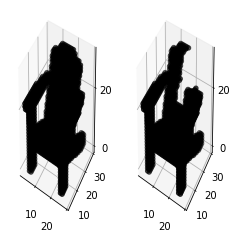

In [7]:
#@title Visualizar {run: "auto"}
id = 197 #@param {type: 'slider', max:888, min:0, step:1}
showArr3DBoolC(Y[id], 1) #completo
showArr3DBoolC(X[id], 2) #fracturado

# DCGAN3D - Pytorch

In [8]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [9]:
torch.manual_seed(0)

In [10]:
def show_tensor_images(image_tensor, size, pos, num_images=9):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=3)
  showArr3DBoolC( image_grid, pos )

In [11]:
#@title Bloque de Convolución 
class ConvBlock(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""
  # def __init__(self, in_channels, out_channels, mid_channels=None):
  #   super().__init__()
  #   if not mid_channels:
  #     mid_channels = out_channels
  #   self.double_conv = nn.Sequential(
  #     nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(mid_channels),
  #     nn.ReLU(inplace=True),
  #     nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(out_channels),
  #     nn.ReLU(inplace=True)
  #   )
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
      nn.BatchNorm3d(out_channels),
      nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.double_conv(x)

In [12]:
#@title Discriminador (Encoder)
class Discriminator(nn.Module):
  """Downscaling """
  
  class Down(nn.Module):
    """[Block] Downscaling with AvgPool then double conv"""
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
        nn.AvgPool3d(kernel_size = 2),
        ConvBlock(in_channels, out_channels)
      )
    def forward(self, x):
      return self.maxpool_conv(x)

  def __init__(self, trilinear=True):
    super(Discriminator, self).__init__()
    self.inc = ConvBlock(1, 32)      #32^3
    self.down1 = self.Down(32, 64)    #16^3
    self.down2 = self.Down(64, 128)   #8^3
    self.down3 = self.Down(128, 256)  #4^3
    self.factor = 2 if trilinear else 1
    self.down4 = self.Down(256, 512 // self.factor)

  def forward(self, x):
    x = self.inc(x)
    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)
    x = self.down4(x)
    return x

In [13]:
#@title Generador (UNet)
class Generator(Discriminator):
  """Downscaling + Upscaling"""
  
  class Up(nn.Module):
    """[Block] Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, trilinear=True):
      super().__init__()
      # if trilinear, use the normal convolutions to reduce the number of channels
      if trilinear:
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels) #, in_channels // 2
      else:
        self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    def forward(self, x1, x2):
      x1 = self.up(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)
    
  def __init__(self, trilinear=True):
    super(Generator, self).__init__(trilinear)
    self.up1 = self.Up(512, 256 // self.factor, trilinear)
    self.up2 = self.Up(256, 128 // self.factor, trilinear)
    self.up3 = self.Up(128, 64 // self.factor, trilinear)
    self.up4 = self.Up(64, 32, trilinear)
    self.outc = ConvBlock(32, 1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

### Funciones de Pérdida

In [14]:
def get_gen_loss(gen, disc, criterion, incomplete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [15]:
def get_disc_loss(gen, disc, criterion, incomplete, complete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(complete)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

# Guardar modelo

In [16]:
from google.colab import drive #, files
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
folder = '/content' #@param {type:'string'}

In [18]:
def save_model(n): #, download:bool = False
  torch.save(disc.state_dict(), f'{folder}/disc_{n}.pth')
  torch.save(gen.state_dict(), f'{folder}/gen_{n}.pth')
  # if download:
  #   files.download(f'{folder}/gen_{n}.pth')
  #   files.download(f'{folder}/disc_{n}.pth')
  print(f'disc_{n}.pth and gen_{n}.pth were saved.')

In [19]:
def load_model(n, model_type:str = 'gen'):
  """ model_type options: 'gen' | 'disc' """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # disc = torch.load(f'{folder}/disc_{n}.pth')
  # disc.eval()
  gen = Generator() if model_type=='gen' else Discriminator()
  gen.load_state_dict(torch.load(f'{folder}/{model_type}_{n}.pth', map_location = device))
  return gen.eval()

# Entrenar

**Dataset**

In [20]:
size = (32,32,32)
# original shape (num_objs, 32, 32, 32)
# shape must be [num_objs, n_channels, depth,height,width]
X = X.reshape( X.shape[0], 1, *size )
Y = Y.reshape( Y.shape[0], 1, *size )

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [22]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [23]:
train_data = TensorDataset(x_train, y_train) #CustomDataset
test_data = TensorDataset(x_test, y_test) #CustomDataset

In [24]:
n_epochs = 200
save_epoch = 10 #@param {type:'slider', min:1, max:200, step:1}
display_step = 500 #@param {type:'slider', min:500, max:1000, step:1}
batch_size = 96
lr = 0.00001

In [25]:
criterion = nn.L1Loss() #.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [26]:
# Step 10000: Generator loss: 0.6930094504356386, discriminator loss: 0.6051261096000671
# Epoch 192: Generator loss: 0.04850963485240936, discriminator loss: 0.042283251881599426
# disc_24.pth and gen_24.pth were saved.
new_models = True #@param {type: 'boolean'}
if new_models:
  gen = Generator().to(device)
  disc = Discriminator().to(device)
else:
  last_n_saved = "8" #@param {type:'string'}
  gen = load_model(last_n_saved, 'gen').to(device)
  disc = load_model(last_n_saved, 'disc').to(device)

In [27]:
# gen_opt = optim.RMSprop(gen.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
gen_opt = optim.Adam(gen.parameters(), lr=lr)
# disc_opt = optim.RMSprop(disc.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
disc_opt = optim.Adam(disc.parameters(), lr=lr)

In [28]:
def train(last_step=0, last_epoch=0):
  cur_step = last_step
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False
  error = False

  for epoch in range(last_epoch,n_epochs):
    for incomplete, complete in tqdm(dataloader):
      cur_batch_size = len(complete)
      complete = complete.to(device=device, dtype=torch.float32)
      incomplete = incomplete.to(device=device, dtype=torch.float32)
      #Loss
      disc_opt.zero_grad()
      disc_loss = get_disc_loss(gen, disc, criterion, incomplete, complete, cur_batch_size, device)
      disc_loss.backward(retain_graph=True)
      disc_opt.step()
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, incomplete, cur_batch_size, device)
      gen_loss.backward()
      gen_opt.step()
      mean_discriminator_loss += disc_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step

      #Display
      if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        fake = gen(incomplete)
        show_tensor_images(incomplete, size, 1)
        show_tensor_images(fake, size, 2)
        show_tensor_images(complete, size, 3)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
      cur_step += 1
    
    print(f"Epoch {epoch} | Step:{cur_step} \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}" )
    #Save
    if epoch % save_epoch == 0 and epoch > 0:
      save_model(epoch//save_epoch)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 0 | Step:52 	 Generator loss: 0.067005184173584, Discriminator loss: 0.054407271146774294


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 | Step:104 	 Generator loss: 0.13055442249774935, Discriminator loss: 0.10639852535724639


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 | Step:156 	 Generator loss: 0.19418892574310295, Discriminator loss: 0.1582722202539444


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 | Step:208 	 Generator loss: 0.2579024747610092, Discriminator loss: 0.21013349020481104


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 | Step:260 	 Generator loss: 0.321907678604126, Discriminator loss: 0.2619051008820533


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 | Step:312 	 Generator loss: 0.38639013814926176, Discriminator loss: 0.3135271019935608


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 | Step:364 	 Generator loss: 0.45158424377441436, Discriminator loss: 0.3649440348148345


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 | Step:416 	 Generator loss: 0.5171779954433443, Discriminator loss: 0.4160296464562417


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 | Step:468 	 Generator loss: 0.5837540756464004, Discriminator loss: 0.46660884708166117


  0%|          | 0/52 [00:00<?, ?it/s]

Step 500: 	 Generator loss: 0.6259462084770201, Discriminator loss: 0.49869717061519636
Epoch 9 | Step:520 	 Generator loss: 0.02440926361083984, Discriminator loss: 0.018302178382873537


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 | Step:572 	 Generator loss: 0.09153397512435918, Discriminator loss: 0.06816742038726807
disc_1.pth and gen_1.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 | Step:624 	 Generator loss: 0.15899689447879795, Discriminator loss: 0.11768483662605284


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 | Step:676 	 Generator loss: 0.2267920871973038, Discriminator loss: 0.16680312889814378


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 | Step:728 	 Generator loss: 0.2950103877782823, Discriminator loss: 0.2155227656364441


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 | Step:780 	 Generator loss: 0.36383213460445435, Discriminator loss: 0.263838381946087


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 | Step:832 	 Generator loss: 0.43355054771900214, Discriminator loss: 0.3118076038360597


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 | Step:884 	 Generator loss: 0.5041734002828602, Discriminator loss: 0.3595178515315059


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 | Step:936 	 Generator loss: 0.5750986744165424, Discriminator loss: 0.4071749989390376


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 | Step:988 	 Generator loss: 0.6454153343439109, Discriminator loss: 0.4549215359091762


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1000: 	 Generator loss: 0.6629768437147145, Discriminator loss: 0.46687240982055694
Epoch 19 | Step:1040 	 Generator loss: 0.052734918475151056, Discriminator loss: 0.03586519384384154


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 | Step:1092 	 Generator loss: 0.1229838433265686, Discriminator loss: 0.08376414746046067
disc_2.pth and gen_2.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 | Step:1144 	 Generator loss: 0.19317624211311332, Discriminator loss: 0.1317959278821945


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 | Step:1196 	 Generator loss: 0.2635006983280181, Discriminator loss: 0.1797596434950828


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 | Step:1248 	 Generator loss: 0.3338354176282882, Discriminator loss: 0.22770708745718


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 | Step:1300 	 Generator loss: 0.4045949426889418, Discriminator loss: 0.2753853779435158


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 | Step:1352 	 Generator loss: 0.47561378681659666, Discriminator loss: 0.3230748551487923


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 | Step:1404 	 Generator loss: 0.5467157180309294, Discriminator loss: 0.370782152414322


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 | Step:1456 	 Generator loss: 0.6180933392047885, Discriminator loss: 0.4183271142840386


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1500: 	 Generator loss: 0.679989527344704, Discriminator loss: 0.4595316145420074
Epoch 28 | Step:1508 	 Generator loss: 0.009582154393196105, Discriminator loss: 0.006408426761627198


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 | Step:1560 	 Generator loss: 0.08101480150222778, Discriminator loss: 0.05407989716529845


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 | Step:1612 	 Generator loss: 0.15311089348793025, Discriminator loss: 0.10133963698148728
disc_3.pth and gen_3.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 | Step:1664 	 Generator loss: 0.22486140573024735, Discriminator loss: 0.14881523758172985


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 | Step:1716 	 Generator loss: 0.2968071587085722, Discriminator loss: 0.19626008415222168


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 | Step:1768 	 Generator loss: 0.3691592603921891, Discriminator loss: 0.24340280085802082


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 | Step:1820 	 Generator loss: 0.4409330352544785, Discriminator loss: 0.2909162161350251


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 | Step:1872 	 Generator loss: 0.5133486291170123, Discriminator loss: 0.3380156859755518


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 | Step:1924 	 Generator loss: 0.5857257475852969, Discriminator loss: 0.3851661753058437


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 | Step:1976 	 Generator loss: 0.6576953014135362, Discriminator loss: 0.4326073464155202


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2000: 	 Generator loss: 0.6925468299388886, Discriminator loss: 0.4552887954115874
Epoch 38 | Step:2028 	 Generator loss: 0.03759688067436219, Discriminator loss: 0.024547600388526915


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 | Step:2080 	 Generator loss: 0.11026041603088378, Discriminator loss: 0.07165925979614254


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 | Step:2132 	 Generator loss: 0.18298221838474257, Discriminator loss: 0.11863591527938838
disc_4.pth and gen_4.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 | Step:2184 	 Generator loss: 0.2556666079759597, Discriminator loss: 0.16562492758035655


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 | Step:2236 	 Generator loss: 0.32845320725440985, Discriminator loss: 0.21256152409315102


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 | Step:2288 	 Generator loss: 0.4003275411128997, Discriminator loss: 0.2602603941559791


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 | Step:2340 	 Generator loss: 0.4733280178308486, Discriminator loss: 0.3070634929537773


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 | Step:2392 	 Generator loss: 0.5459137235879897, Discriminator loss: 0.3541674032211304


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 | Step:2444 	 Generator loss: 0.6190445206165315, Discriminator loss: 0.4010495878458021


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 | Step:2496 	 Generator loss: 0.6919917992353445, Discriminator loss: 0.4479986780881881


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2500: 	 Generator loss: 0.6991104806661611, Discriminator loss: 0.4526068013310432
Epoch 48 | Step:2548 	 Generator loss: 0.06549380588531495, Discriminator loss: 0.04266073662042618


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 | Step:2600 	 Generator loss: 0.13835507118701929, Discriminator loss: 0.08959791433811187


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 | Step:2652 	 Generator loss: 0.21136888003349288, Discriminator loss: 0.13653782361745828
disc_5.pth and gen_5.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 | Step:2704 	 Generator loss: 0.2841527256965636, Discriminator loss: 0.18386269122362148


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 | Step:2756 	 Generator loss: 0.35685708928108206, Discriminator loss: 0.23097958153486267


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 | Step:2808 	 Generator loss: 0.43001434373855585, Discriminator loss: 0.2777891319394112


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 | Step:2860 	 Generator loss: 0.5027756636142731, Discriminator loss: 0.32518105781078344


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 | Step:2912 	 Generator loss: 0.5756629951000212, Discriminator loss: 0.3723039622306824


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 | Step:2964 	 Generator loss: 0.6487636297941202, Discriminator loss: 0.41935041970014564


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3000: 	 Generator loss: 0.7008985953330988, Discriminator loss: 0.4526527863144874
Epoch 57 | Step:3016 	 Generator loss: 0.02102783751487732, Discriminator loss: 0.013628199040889742


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58 | Step:3068 	 Generator loss: 0.0944184501171112, Discriminator loss: 0.060272764742374405


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 | Step:3120 	 Generator loss: 0.16736560833454134, Discriminator loss: 0.10724919819831845


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 | Step:3172 	 Generator loss: 0.2407518486976625, Discriminator loss: 0.1538544912934303
disc_6.pth and gen_6.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 | Step:3224 	 Generator loss: 0.3141997238397599, Discriminator loss: 0.20054966711997976


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 | Step:3276 	 Generator loss: 0.38730813336372394, Discriminator loss: 0.2475454885363578


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 | Step:3328 	 Generator loss: 0.4611301813125613, Discriminator loss: 0.29416842961311324


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 | Step:3380 	 Generator loss: 0.5343166421651845, Discriminator loss: 0.34112084704637524


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 | Step:3432 	 Generator loss: 0.6078190273046495, Discriminator loss: 0.38779684621095656


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 | Step:3484 	 Generator loss: 0.6815598603487014, Discriminator loss: 0.4343465916514396


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3500: 	 Generator loss: 0.7053297365903854, Discriminator loss: 0.4499742274880407
Epoch 67 | Step:3536 	 Generator loss: 0.04972644555568696, Discriminator loss: 0.0313238308429718


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68 | Step:3588 	 Generator loss: 0.12332707524299617, Discriminator loss: 0.0778722110390663


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 | Step:3640 	 Generator loss: 0.19685077905654896, Discriminator loss: 0.12459969902038577


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 | Step:3692 	 Generator loss: 0.27058687460422504, Discriminator loss: 0.17135211139917386
disc_7.pth and gen_7.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 | Step:3744 	 Generator loss: 0.3439586751461025, Discriminator loss: 0.21822381687164316


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 | Step:3796 	 Generator loss: 0.4180286065340038, Discriminator loss: 0.26453611069917704


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 | Step:3848 	 Generator loss: 0.491408176064491, Discriminator loss: 0.3113789063692096


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 | Step:3900 	 Generator loss: 0.5647425969839095, Discriminator loss: 0.3583897510766986


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 | Step:3952 	 Generator loss: 0.6383181749582291, Discriminator loss: 0.40516008818149596


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4000: 	 Generator loss: 0.7076155346632002, Discriminator loss: 0.449208204030991
Epoch 76 | Step:4004 	 Generator loss: 0.004289780855178833, Discriminator loss: 0.0026208249926567076


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77 | Step:4056 	 Generator loss: 0.07832163846492766, Discriminator loss: 0.04901891535520554


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 | Step:4108 	 Generator loss: 0.15277845144271862, Discriminator loss: 0.09508283644914624


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 | Step:4160 	 Generator loss: 0.22649329793453232, Discriminator loss: 0.14172542041540145


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 | Step:4212 	 Generator loss: 0.30067979574203507, Discriminator loss: 0.18799995350837714
disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 | Step:4264 	 Generator loss: 0.37478165435791005, Discriminator loss: 0.2345635101795197


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 | Step:4316 	 Generator loss: 0.44928924047946905, Discriminator loss: 0.28067869949340823


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 | Step:4368 	 Generator loss: 0.523484194874763, Discriminator loss: 0.3270585607290268


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 | Step:4420 	 Generator loss: 0.5978679821491241, Discriminator loss: 0.3732813533544543


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 | Step:4472 	 Generator loss: 0.671743460178375, Discriminator loss: 0.41991462606191654


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: 	 Generator loss: 0.713439463853836, Discriminator loss: 0.4455583678483964
Epoch 86 | Step:4524 	 Generator loss: 0.03284642851352691, Discriminator loss: 0.0205136022567749


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 | Step:4576 	 Generator loss: 0.10722954857349395, Discriminator loss: 0.06674229645729066


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 | Step:4628 	 Generator loss: 0.18094269514083858, Discriminator loss: 0.11359672784805301


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 | Step:4680 	 Generator loss: 0.25576365864276884, Discriminator loss: 0.15963443511724473


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 | Step:4732 	 Generator loss: 0.33014282953739166, Discriminator loss: 0.20585565781593326
disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 | Step:4784 	 Generator loss: 0.4047073380947113, Discriminator loss: 0.25205952513217916


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 | Step:4836 	 Generator loss: 0.47927214741706853, Discriminator loss: 0.29839145976304976


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 | Step:4888 	 Generator loss: 0.5538803751468658, Discriminator loss: 0.34445600402355164


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 | Step:4940 	 Generator loss: 0.627736428141594, Discriminator loss: 0.3912400605082509


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 95 | Step:4992 	 Generator loss: 0.7024083217382429, Discriminator loss: 0.4373232119083401


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5000: 	 Generator loss: 0.715296407818794, Discriminator loss: 0.4453990800976749
Epoch 96 | Step:5044 	 Generator loss: 0.062029262661933884, Discriminator loss: 0.038150658726692196


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97 | Step:5096 	 Generator loss: 0.13713542354106906, Discriminator loss: 0.0838935176134109


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 | Step:5148 	 Generator loss: 0.21163002347946167, Discriminator loss: 0.13016255480051034


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 | Step:5200 	 Generator loss: 0.2864213893413543, Discriminator loss: 0.17630490803718576


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 | Step:5252 	 Generator loss: 0.36126471769809715, Discriminator loss: 0.2222610443830491
disc_10.pth and gen_10.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 101 | Step:5304 	 Generator loss: 0.4354951115846635, Discriminator loss: 0.2689170310497285


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 102 | Step:5356 	 Generator loss: 0.5105551471710205, Discriminator loss: 0.3146677601933483


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 103 | Step:5408 	 Generator loss: 0.5857537959814074, Discriminator loss: 0.3604451949000361


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 104 | Step:5460 	 Generator loss: 0.6610543037652971, Discriminator loss: 0.4063723528385166


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5500: 	 Generator loss: 0.7202979326248169, Discriminator loss: 0.44241330593824435
Epoch 105 | Step:5512 	 Generator loss: 0.015943174362182615, Discriminator loss: 0.009709806203842165


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 106 | Step:5564 	 Generator loss: 0.09080617773532869, Discriminator loss: 0.05572110480070114


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 107 | Step:5616 	 Generator loss: 0.16557192087173458, Discriminator loss: 0.10202043867111203


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 108 | Step:5668 	 Generator loss: 0.24079143011569976, Discriminator loss: 0.1478884379863738


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 109 | Step:5720 	 Generator loss: 0.31542132806777945, Discriminator loss: 0.19405592906475053


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 110 | Step:5772 	 Generator loss: 0.39100272464752195, Discriminator loss: 0.2396271549463271
disc_11.pth and gen_11.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 111 | Step:5824 	 Generator loss: 0.4666370569467544, Discriminator loss: 0.2853183170557021


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 112 | Step:5876 	 Generator loss: 0.5414833334684375, Discriminator loss: 0.3312189545631407


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 113 | Step:5928 	 Generator loss: 0.6154564462900162, Discriminator loss: 0.37819046288728686


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 114 | Step:5980 	 Generator loss: 0.689928206562996, Discriminator loss: 0.424857917308807


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6000: 	 Generator loss: 0.7203781815767288, Discriminator loss: 0.443397318065166
Epoch 115 | Step:6032 	 Generator loss: 0.044457762598991396, Discriminator loss: 0.027561884522438046


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 116 | Step:6084 	 Generator loss: 0.120084375500679, Discriminator loss: 0.07322168827056884


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 117 | Step:6136 	 Generator loss: 0.19552717065811154, Discriminator loss: 0.11884921628236772


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 118 | Step:6188 	 Generator loss: 0.2708493586778641, Discriminator loss: 0.16476519870758058


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 119 | Step:6240 	 Generator loss: 0.3458997372388838, Discriminator loss: 0.2108354979753494


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 120 | Step:6292 	 Generator loss: 0.4213679653406142, Discriminator loss: 0.25643543338775626
disc_12.pth and gen_12.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 121 | Step:6344 	 Generator loss: 0.496971006989479, Discriminator loss: 0.30211239933967604


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 122 | Step:6396 	 Generator loss: 0.572153166174889, Discriminator loss: 0.34795888453722007


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 123 | Step:6448 	 Generator loss: 0.6476891154050831, Discriminator loss: 0.3937070932388306


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 124 | Step:6500 	 Generator loss: 0.7233374892473223, Discriminator loss: 0.43941633188724527


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6500: 	 Generator loss: 0.7248342069387438, Discriminator loss: 0.4402666320800782
Epoch 125 | Step:6552 	 Generator loss: 0.07404007339477536, Discriminator loss: 0.044809915542602545


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 126 | Step:6604 	 Generator loss: 0.14990735375881195, Discriminator loss: 0.09014172184467316


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 127 | Step:6656 	 Generator loss: 0.22601370215415964, Discriminator loss: 0.13550901901721954


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 128 | Step:6708 	 Generator loss: 0.30150820946693446, Discriminator loss: 0.18136515992879867


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 129 | Step:6760 	 Generator loss: 0.376624930739403, Discriminator loss: 0.22729305344820028


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 130 | Step:6812 	 Generator loss: 0.45256509935855915, Discriminator loss: 0.2727033600807192
disc_13.pth and gen_13.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 131 | Step:6864 	 Generator loss: 0.5273769655227667, Discriminator loss: 0.3187546190023422


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 132 | Step:6916 	 Generator loss: 0.6033834244012837, Discriminator loss: 0.3640079631209372


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 133 | Step:6968 	 Generator loss: 0.6788240212202075, Discriminator loss: 0.409945949792862


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7000: 	 Generator loss: 0.7270586971044541, Discriminator loss: 0.4389256702661514
Epoch 134 | Step:7020 	 Generator loss: 0.027794479370117184, Discriminator loss: 0.01649406510591507


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 135 | Step:7072 	 Generator loss: 0.10377949953079225, Discriminator loss: 0.06176503181457521


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 136 | Step:7124 	 Generator loss: 0.17952654469013213, Discriminator loss: 0.10728563868999479


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 137 | Step:7176 	 Generator loss: 0.2551850405931472, Discriminator loss: 0.1530418611764908


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 138 | Step:7228 	 Generator loss: 0.33100893461704245, Discriminator loss: 0.1985198045372963


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 139 | Step:7280 	 Generator loss: 0.40671294212341313, Discriminator loss: 0.2442319737672806


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 140 | Step:7332 	 Generator loss: 0.482680272102356, Discriminator loss: 0.28957373416423793
disc_14.pth and gen_14.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 141 | Step:7384 	 Generator loss: 0.5573011022806171, Discriminator loss: 0.3360816915035247


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 142 | Step:7436 	 Generator loss: 0.6329587851762773, Discriminator loss: 0.3818190138339995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 143 | Step:7488 	 Generator loss: 0.7090689393281937, Discriminator loss: 0.42719345080852517


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7500: 	 Generator loss: 0.7283095078468323, Discriminator loss: 0.43834987074136733
Epoch 144 | Step:7540 	 Generator loss: 0.05752418661117554, Discriminator loss: 0.033478986024856563


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 145 | Step:7592 	 Generator loss: 0.13340345692634586, Discriminator loss: 0.07923424148559569


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 146 | Step:7644 	 Generator loss: 0.20950203716754928, Discriminator loss: 0.12466914671659465


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 147 | Step:7696 	 Generator loss: 0.28552611947059636, Discriminator loss: 0.17021363198757167


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 148 | Step:7748 	 Generator loss: 0.3623935604095459, Discriminator loss: 0.2151153534650802


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 149 | Step:7800 	 Generator loss: 0.43921862876415263, Discriminator loss: 0.25997715038061125


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 150 | Step:7852 	 Generator loss: 0.5153589884042741, Discriminator loss: 0.30536040771007517
disc_15.pth and gen_15.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 151 | Step:7904 	 Generator loss: 0.5916554640531537, Discriminator loss: 0.35051334065198875


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 152 | Step:7956 	 Generator loss: 0.6664718781709669, Discriminator loss: 0.3968972267508504


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8000: 	 Generator loss: 0.7327391972541807, Discriminator loss: 0.43588821691274604
Epoch 153 | Step:8008 	 Generator loss: 0.010370813608169556, Discriminator loss: 0.006016131639480591


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 154 | Step:8060 	 Generator loss: 0.08678821980953214, Discriminator loss: 0.050990160107612606


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 155 | Step:8112 	 Generator loss: 0.1624660714864731, Discriminator loss: 0.0972354171872139


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 156 | Step:8164 	 Generator loss: 0.23878579401969913, Discriminator loss: 0.14246909105777736


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 157 | Step:8216 	 Generator loss: 0.31471697580814373, Discriminator loss: 0.18814587771892544


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 158 | Step:8268 	 Generator loss: 0.3913088910579681, Discriminator loss: 0.23308472198247904


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 159 | Step:8320 	 Generator loss: 0.46711585688591006, Discriminator loss: 0.27871100777387625


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 160 | Step:8372 	 Generator loss: 0.5441367563009262, Discriminator loss: 0.32411595290899275
disc_16.pth and gen_16.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 161 | Step:8424 	 Generator loss: 0.6210300809144974, Discriminator loss: 0.3691238465309143


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 162 | Step:8476 	 Generator loss: 0.697108434200287, Discriminator loss: 0.4144362302422523


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8500: 	 Generator loss: 0.7337963367700576, Discriminator loss: 0.43634007781743994
Epoch 163 | Step:8528 	 Generator loss: 0.039871226429939274, Discriminator loss: 0.023191315829753877


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 164 | Step:8580 	 Generator loss: 0.115547266125679, Discriminator loss: 0.0689996420145035


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 165 | Step:8632 	 Generator loss: 0.19257324135303489, Discriminator loss: 0.11373108989000325


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 166 | Step:8684 	 Generator loss: 0.2680087605714797, Discriminator loss: 0.15987565094232561


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 167 | Step:8736 	 Generator loss: 0.34376201128959644, Discriminator loss: 0.20564894974231726


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 168 | Step:8788 	 Generator loss: 0.4205356625318526, Discriminator loss: 0.25057583630084995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 169 | Step:8840 	 Generator loss: 0.495831905722618, Discriminator loss: 0.2966621745228769


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 170 | Step:8892 	 Generator loss: 0.5719121787548064, Discriminator loss: 0.342063708484173
disc_17.pth and gen_17.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 171 | Step:8944 	 Generator loss: 0.6488706339597701, Discriminator loss: 0.3870736901164056


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 172 | Step:8996 	 Generator loss: 0.7255398656129833, Discriminator loss: 0.4323763571381569


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9000: 	 Generator loss: 0.7330093221664425, Discriminator loss: 0.43660290098190313
Epoch 173 | Step:9048 	 Generator loss: 0.06936878371238708, Discriminator loss: 0.040516527891159046


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 174 | Step:9100 	 Generator loss: 0.1464034227132797, Discriminator loss: 0.08529253941774372


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 175 | Step:9152 	 Generator loss: 0.22369690632820124, Discriminator loss: 0.12997519844770436


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 176 | Step:9204 	 Generator loss: 0.3000641965866089, Discriminator loss: 0.1752856411337853


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 177 | Step:9256 	 Generator loss: 0.376948848724365, Discriminator loss: 0.22022462159395217


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 178 | Step:9308 	 Generator loss: 0.4531479166746138, Discriminator loss: 0.26567740070819856


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 179 | Step:9360 	 Generator loss: 0.5300723536014555, Discriminator loss: 0.31053888094425186


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 180 | Step:9412 	 Generator loss: 0.6072692127227787, Discriminator loss: 0.3554403371214864
disc_18.pth and gen_18.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 181 | Step:9464 	 Generator loss: 0.6845688904523852, Discriminator loss: 0.40004662090539905


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9500: 	 Generator loss: 0.7393774917125703, Discriminator loss: 0.43200107383728004
Epoch 182 | Step:9516 	 Generator loss: 0.02251077938079834, Discriminator loss: 0.012648508191108705


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 183 | Step:9568 	 Generator loss: 0.0996620819568634, Discriminator loss: 0.05735071742534636


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 184 | Step:9620 	 Generator loss: 0.17654717588424684, Discriminator loss: 0.10236505055427549


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 185 | Step:9672 	 Generator loss: 0.25239845693111423, Discriminator loss: 0.1479102443456649


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 186 | Step:9724 	 Generator loss: 0.32893059194088003, Discriminator loss: 0.19293429613113403


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 187 | Step:9776 	 Generator loss: 0.4061415150165558, Discriminator loss: 0.23783908909559243


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 188 | Step:9828 	 Generator loss: 0.48254596590995796, Discriminator loss: 0.28319140034914014


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 189 | Step:9880 	 Generator loss: 0.5600778810977936, Discriminator loss: 0.3274121123552323


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 190 | Step:9932 	 Generator loss: 0.6370658245086671, Discriminator loss: 0.37224139100313186
disc_19.pth and gen_19.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 191 | Step:9984 	 Generator loss: 0.7146530030965804, Discriminator loss: 0.4167883903980254


  0%|          | 0/52 [00:00<?, ?it/s]

Step 10000: 	 Generator loss: 0.73946291410923, Discriminator loss: 0.4318686209917068
Epoch 192 | Step:10036 	 Generator loss: 0.05213740599155426, Discriminator loss: 0.030301778376102446


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 193 | Step:10088 	 Generator loss: 0.12929026293754575, Discriminator loss: 0.07502060186862945


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 194 | Step:10140 	 Generator loss: 0.20619594573974612, Discriminator loss: 0.12014495629072193


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 195 | Step:10192 	 Generator loss: 0.28354453599452983, Discriminator loss: 0.1649428980350495


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 196 | Step:10244 	 Generator loss: 0.36002103090286247, Discriminator loss: 0.21051650685071954


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 197 | Step:10296 	 Generator loss: 0.43719301116466514, Discriminator loss: 0.255211699306965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 198 | Step:10348 	 Generator loss: 0.5150702226161956, Discriminator loss: 0.29942790120840096


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 199 | Step:10400 	 Generator loss: 0.5913506857156752, Discriminator loss: 0.34522288995981243


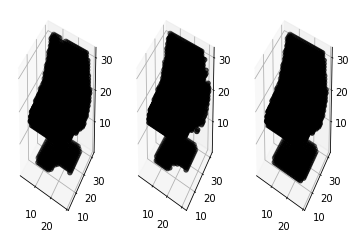

In [29]:
train(last_step=0, last_epoch=0)

In [36]:
save_model('last')

disc_last.pth and gen_last.pth were saved.


In [31]:
# limpiar memoria
# with torch.no_grad():
#   torch.cuda.empty_cache()

In [41]:
from google.colab import files

In [43]:
files.download('/content/disc_last.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/gen_last.pth')